In [224]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [225]:
titanic_data = pd.read_csv('train.csv')

In [226]:
titanic_data

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

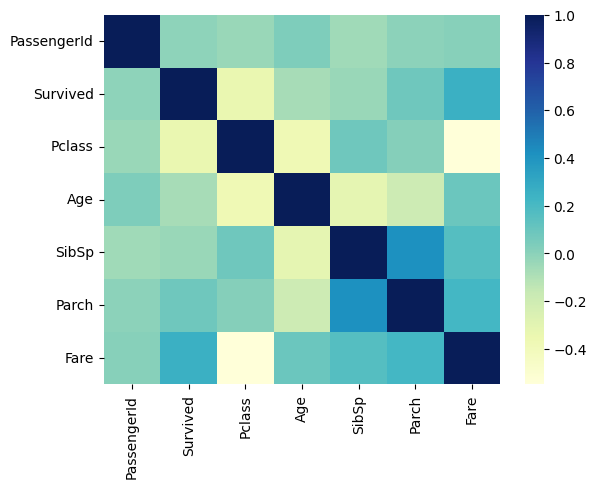

In [227]:
sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")
plt.show()

In [228]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_idx]
    strat_test_set = titanic_data.loc[test_idx]

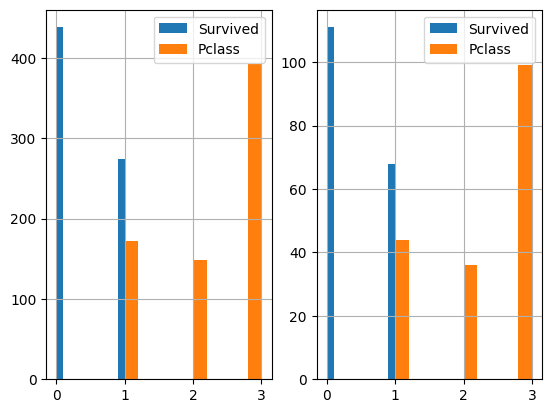

In [229]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist(label='Survived')
strat_train_set['Pclass'].hist(label='Pclass')
plt.legend()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist(label='Survived')
strat_test_set['Pclass'].hist(label='Pclass')
plt.legend()

plt.show()

In [230]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [231]:
median_age_train = strat_train_set["Age"].median()
strat_train_set["Age"] = strat_train_set["Age"].fillna(median_age_train)

median_age_test = strat_test_set["Age"].median()
strat_test_set["Age"] = strat_test_set["Age"].fillna(median_age_test)

In [232]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X

In [233]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Embarked", "Sex", "Cabin", "Name", "Ticket", "N"], axis = 1, errors='ignore')

In [234]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])


In [235]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [236]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [237]:
strat_test_set = pipeline.fit_transform(strat_test_set)
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 659 to 104
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Age          179 non-null    float64
 4   SibSp        179 non-null    int64  
 5   Parch        179 non-null    int64  
 6   Fare         179 non-null    float64
 7   C            179 non-null    float64
 8   S            179 non-null    float64
 9   Q            179 non-null    float64
 10  Female       179 non-null    float64
 11  Male         179 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 18.2 KB


In [238]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

params = [
    {"n_estimators": [10, 100, 300, 500], "max_depth": [None, 5, 10], "min_samples_split":[2, 3, 4]}
]

grid_search = GridSearchCV(clf, params, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 300, 500]}],
             return_train_score=True, scoring='accuracy')

In [239]:
final_clf = grid_search.best_estimator_

In [240]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=300)

In [241]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [242]:
final_clf.score(X_data_test, y_data_test)

0.8547486033519553

In [243]:
median_age = titanic_data["Age"].median()
titanic_data["Age"] = titanic_data["Age"].fillna(median_age)

In [244]:
final_data = pipeline.fit_transform(titanic_data)

In [245]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [151]:
prod_clf = RandomForestClassifier()

params = [
    {"n_estimators": [10, 100, 300, 500], "max_depth": [None, 5, 10], "min_samples_split":[2, 3, 4]}
]

grid_search = GridSearchCV(prod_clf, params, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 300, 500]}],
             return_train_score=True, scoring='accuracy')

In [246]:
prod_final_clf = grid_search.best_estimator_

In [247]:
prod_final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=300)

In [248]:
titanic_test_data = pd.read_csv('test.csv')

In [249]:
median_age = titanic_test_data["Age"].median()
titanic_test_data["Age"] = titanic_test_data["Age"].fillna(median_age)

final_test_data = pipeline.fit_transform(titanic_test_data)

In [250]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\DELL\AppData\Local\Temp\ipykernel_8484\1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [251]:
predictions = prod_final_clf.predict(X_data_final_test)

In [252]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions1.csv", index=False)